In [55]:
# Installation TensorFlow
!pip install --upgrade tensorflow -q

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# Import des librairies TensorFlow & Pathlib 
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
tf.__version__

'2.6.0'

In [58]:
# Import the dataset in Pandas 
df_train = pd.read_csv("/content/drive/MyDrive/DATA/train45.csv")
df_train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [59]:
display(100*df_train.isnull().sum()/df_train.shape[0])

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [ ]:
set(df_train["keyword"])
set(df_train["location"])

In [61]:
df_train = df_train[['text', 'target']]
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [62]:
df_train["target"].value_counts() #dataset is a bit biaised in favor of  non catastrophic tweets

0    4342
1    3271
Name: target, dtype: int64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


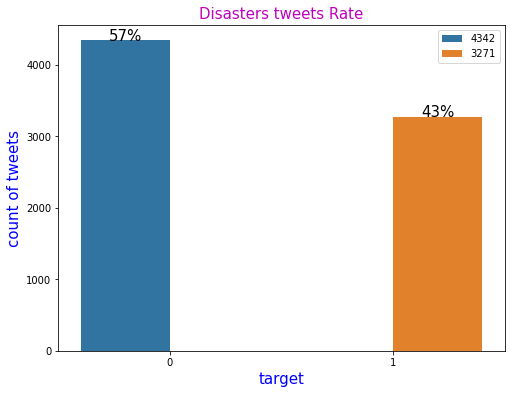

In [63]:
fig, ax = plt.subplots(1, figsize=(8,6))
sns.countplot(data = df_train, x = 'target', hue='target', ax=ax)
plt.legend([index for index in df_train['target'].value_counts()])
plt.title('Disasters tweets Rate', fontsize=15, color='m')
plt.xlabel('target', fontsize=15, color='b')
plt.ylabel('count of tweets', fontsize=15, color='b')
for z in range(1):
    for p in ax.patches:
      total = float(len(df_train))
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
      height + 3, '{0:.0%}'.format(height/total), ha="center", fontsize=15)
plt.show()

In [64]:
from spacy.lang.en import English

In [65]:
#Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [66]:
nlp=spacy.load("en_core_web_sm")

In [67]:
df_train.iloc[0,:]

text      Our Deeds are the Reason of this #earthquake M...
target                                                    1
Name: 0, dtype: object

In [68]:
df_train["text_clean"]= df_train["text"].apply(lambda x: re.sub(r'http\S+', '', x))

In [69]:
df_train

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.
7611,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...


In [70]:
#cleaning dataset
df_train['text_clean'] = df_train['text'].str.replace('\d+', '')
df_train["text_clean"]= df_train["text_clean"].apply(lambda x: re.sub(r'http\S+', '', x)) #delete http adresses
df_train["text_clean"] = df_train["text_clean"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch in [" ","'"]))
df_train["text_clean"] = df_train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_train["text_clean"] = df_train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

In [71]:
df_train
df_train.shape

(7613, 3)

In [72]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(1500)
tokenizer.fit_on_texts(df_train.text_clean)

df_train["text_encoded"] = tokenizer.texts_to_sequences(df_train.text_clean)
df_train["len_text"] = df_train["text_encoded"].apply(lambda x: len(x))
df_train = df_train[df_train["len_text"]!=0]

df_train


,text,target,text_clean,text_encoded,len_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[403, 164, 1336]",3
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[109, 3, 154, 482, 943]",5
2,All residents asked to 'shelter in place' are ...,1,resident ask ' shelter place ' notify officer ...,"[1337, 438, 1, 309, 1, 284, 179, 309, 285, 374]",10
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,"[6, 67, 179, 285, 33]",5
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school,"[170, 115, 1474, 165, 67, 103]",6
...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home,"[577, 924, 303, 238, 39, 477, 24]",7
7609,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...,"[541, 208, 3, 33, 121, 172]",6
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utckm s volcano hawaii,"[212, 69, 385, 1208]",4
7611,Police investigating after an e-bike collided ...,1,police investigate ebike collide car little po...,"[22, 719, 83, 42, 203, 1483, 1109, 925, 72]",9


In [73]:
#Padding sequences
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(df_train["text_encoded"], padding="post")

In [74]:
full_ds = tf.data.Dataset.from_tensor_slices((padded_sequences, df_train["target"]))

In [75]:
full_ds

<TensorSliceDataset shapes: ((18,), ()), types: (tf.int32, tf.int64)>

In [76]:
# Shuffle & Batch
BATCH_SIZE = 32
vocab_size = len(tokenizer.word_index)

In [77]:
next(iter(full_ds))

(<tf.Tensor: shape=(18,), dtype=int32, numpy=
 array([ 403,  164, 1336,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [78]:
# Train Test Split
TAKE_SIZE = int(0.7*df_train.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(16)

test_data = full_ds.skip(TAKE_SIZE).shuffle(df_train.shape[0]-TAKE_SIZE)
test_data = test_data.batch(16)

In [79]:
# Create the model
model1 = tf.keras.Sequential([
                  # Input Word Embedding layer        
                  tf.keras.layers.Embedding(vocab_size+1, 64, mask_zero=True),
                  #Drop Out
                  tf.keras.layers.Dropout(.2),
                  # LSTM Bidirectional layer
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                  #Drop Out
                  tf.keras.layers.Dropout(.2),
                  # LSTM Bidirectionnal new layer
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                  #Drop Out
                  tf.keras.layers.Dropout(.2),
                  # LSTM new layer
                  tf.keras.layers.LSTM(32, return_sequences=False),
                #Drop Out
                  tf.keras.layers.Dropout(.2)   ,           
                  # Output layer with number of output neurons equal to class number with softmax function
                  #tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size+1, activation="softmax")),
                  # Couche Dense classique
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),
                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [80]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          961152    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)               

In [81]:
optimizer= tf.keras.optimizers.Adam()
model1.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [82]:
# Application of the model on 10 epochs
history = model1.fit(train_data,
                    validation_data=test_data,
                    epochs=10)

Epoch 1/10
331/331 [==============================] - 51s 99ms/step - loss: 0.5453 - binary_accuracy: 0.7361 - val_loss: 0.5009 - val_binary_accuracy: 0.7579
Epoch 2/10
331/331 [==============================] - 27s 81ms/step - loss: 0.4107 - binary_accuracy: 0.8287 - val_loss: 0.5055 - val_binary_accuracy: 0.7593
Epoch 3/10
331/331 [==============================] - 27s 81ms/step - loss: 0.3566 - binary_accuracy: 0.8531 - val_loss: 0.5611 - val_binary_accuracy: 0.7469
Epoch 4/10
331/331 [==============================] - 27s 81ms/step - loss: 0.3216 - binary_accuracy: 0.8732 - val_loss: 0.5777 - val_binary_accuracy: 0.7249
Epoch 5/10
331/331 [==============================] - 27s 81ms/step - loss: 0.2837 - binary_accuracy: 0.8911 - val_loss: 0.7033 - val_binary_accuracy: 0.7205
Epoch 6/10
331/331 [==============================] - 27s 81ms/step - loss: 0.2609 - binary_accuracy: 0.9030 - val_loss: 0.8375 - val_binary_accuracy: 0.7063
Epoch 7/10
331/331 [==============================] 

In [83]:
model1.predict(train_data)

array([[0.99951494],
       [0.8900569 ],
       [0.0141795 ],
       ...,
       [0.9997127 ],
       [0.9997107 ],
       [0.86724865]], dtype=float32)

In [84]:
model1.predict(test_data)                                   

array([[0.00152096],
       [0.99943835],
       [0.9967135 ],
       ...,
       [0.48974937],
       [0.99903625],
       [0.27948153]], dtype=float32)

In [85]:
mod_pred=model1.predict(test_data)>.5
mod_pred=pd.DataFrame(mod_pred)
mod_pred.head()

,0
0,True
1,True
2,False
3,False
4,False


In [86]:
mod_pred[0]=mod_pred[0].apply(int)
mod_pred.head()

,0
0,1
1,1
2,0
3,0
4,0


In [87]:
test_dataset=pd.DataFrame(test_data.unbatch())
type(test_dataset)

pandas.core.frame.DataFrame

In [88]:
test_dataset

,0,1
0,"(tf.Tensor(22, shape=(), dtype=int32), tf.Tens...","tf.Tensor(1, shape=(), dtype=int64)"
1,"(tf.Tensor(126, shape=(), dtype=int32), tf.Ten...","tf.Tensor(0, shape=(), dtype=int64)"
2,"(tf.Tensor(1423, shape=(), dtype=int32), tf.Te...","tf.Tensor(1, shape=(), dtype=int64)"
3,"(tf.Tensor(35, shape=(), dtype=int32), tf.Tens...","tf.Tensor(1, shape=(), dtype=int64)"
4,"(tf.Tensor(38, shape=(), dtype=int32), tf.Tens...","tf.Tensor(0, shape=(), dtype=int64)"
...,...,...
2263,"(tf.Tensor(385, shape=(), dtype=int32), tf.Ten...","tf.Tensor(1, shape=(), dtype=int64)"
2264,"(tf.Tensor(85, shape=(), dtype=int32), tf.Tens...","tf.Tensor(0, shape=(), dtype=int64)"
2265,"(tf.Tensor(153, shape=(), dtype=int32), tf.Ten...","tf.Tensor(0, shape=(), dtype=int64)"
2266,"(tf.Tensor(20, shape=(), dtype=int32), tf.Tens...","tf.Tensor(1, shape=(), dtype=int64)"


In [89]:
test_dataset[0] = test_dataset[0].apply(lambda x: [i.numpy() for i in x])   #permet d'extraire les valeurs du tuple, itère sur autres lignes

In [90]:
test_dataset[1] = test_dataset[1].apply(lambda x: x.numpy())

In [91]:
test_dataset[1]
test_dataset.head()

,0,1
0,"[22, 284, 76, 191, 58, 684, 625, 0, 0, 0, 0, 0...",1
1,"[126, 244, 385, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[1423, 364, 77, 22, 998, 819, 0, 0, 0, 0, 0, 0...",1
3,"[35, 391, 373, 298, 233, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[38, 55, 379, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [92]:
#untokenize mots + appliquer le mask pour ne garder que les false et voir ce qui pêche.
test_dataset["detokenize"]=tokenizer.sequences_to_texts(test_dataset[0])

In [98]:
mask=test_dataset[1]!=mod_pred[0]
test_dataset_mask=test_dataset.loc[mask,:]
test_dataset_mask

,0,1,detokenize
1,"[126, 244, 385, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,try blood volcano
2,"[1423, 364, 77, 22, 998, 819, 0, 0, 0, 0, 0, 0...",1,kidnap lady rescue police enugu nigerian
3,"[35, 391, 373, 298, 233, 0, 0, 0, 0, 0, 0, 0, ...",1,watch airport swallow sandstorm minute
6,"[216, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,ruin life
11,"[152, 400, 464, 450, 500, 42, 0, 0, 0, 0, 0, 0...",1,hope tsunami b walk outside car
...,...,...,...
2258,"[555, 285, 47, 297, 249, 0, 0, 0, 0, 0, 0, 0, ...",0,course order cause structural failure
2262,"[196, 95, 309, 941, 24, 377, 797, 393, 0, 0, 0...",1,official quarantine place alabama home possibl...
2263,"[385, 1037, 471, 970, 9, 638, 0, 0, 0, 0, 0, 0...",1,volcano spark transport picture video mount
2266,"[20, 2, 55, 379, 500, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,look like war zone outside


In [94]:
test_dataset_mask[1].value_counts()

0    622
1    532
Name: 1, dtype: int64

In [95]:
df_train

,text,target,text_clean,text_encoded,len_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[403, 164, 1336]",3
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[109, 3, 154, 482, 943]",5
2,All residents asked to 'shelter in place' are ...,1,resident ask ' shelter place ' notify officer ...,"[1337, 438, 1, 309, 1, 284, 179, 309, 285, 374]",10
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,"[6, 67, 179, 285, 33]",5
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school,"[170, 115, 1474, 165, 67, 103]",6
...,...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home,"[577, 924, 303, 238, 39, 477, 24]",7
7609,@aria_ahrary @TheTawniest The out of control w...,1,ariaahrary thetawniest control wild fire calif...,"[541, 208, 3, 33, 121, 172]",6
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utckm s volcano hawaii,"[212, 69, 385, 1208]",4
7611,Police investigating after an e-bike collided ...,1,police investigate ebike collide car little po...,"[22, 719, 83, 42, 203, 1483, 1109, 925, 72]",9


En conclusion nous constatons une mauvaise labelisation de notre test set.

Notre modèle étant mal entrainé il nous propose de mauvaise prédiction.

***Pour aller plus loin on pourrait :***

1.   Afficher le text d'origine à coté de text_clean pour avoir plus de détails.
2.   Classer les mauvaises prédictions en les regroupant par les mots les plus fréquent et essayer de voir sur quel genre de prédiction notre modèle se trompe le plus, pour identifier plus précisément un biais éventuel

In [104]:
print("""
En conclusion nous constatons une mauvaise labelisation de notre test set.
Notre modèle étant mal entrainé il nous propose de mauvaise prédiction.

Pour aller plus loin on pourrait:

    -Afficher le text d'origine à coté de text_clean pour avoir plus de détails.

    -Classer les mauvaises prédictions en les regroupant par les mots les plus fréquent et 
    essayer de voir sur quel genre de prédiction notre modèle se trompe le plus, pour identifier plus précisément un biais éventuel.
""")


En conclusion nous constaton une mauvaise labelisation de notre test set.
Notre modèle étant mal entrainé il nous propose de mauvaise prédiction.

Pour aller plus loin on pourrait:

    -Afficher le text d'origine à coté de text_clean pour avoir plus de détails.

    -Classer les mauvaises prédictions en les regroupant par les mots les plus fréquent et essayer de voir sur quel genre de prédiction notre modèle se trompe le plus, pour identifier plus précisément un biais éventuel.



```
En conclusion nous constatons une mauvaise labelisation de notre test set.
Notre modèle étant mal entrainé il nous propose de mauvaise prédiction.

Pour aller plus loin on pourrait:

    -Afficher le text d'origine à coté de text_clean pour avoir plus de détails.

    -Classer les mauvaises prédictions en les regroupant par les mots les plus fréquent et essayer de voir sur quel genre de prédiction notre modèle se trompe le plus, pour identifier plus précisément un biais éventuel
```